In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_062.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/08_00_082.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-52.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_242.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_013.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-22.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F10-43.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F66-12.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_193.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/10_00_063.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F5-2.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_133.p

Importing Dependencies

In [5]:
import torch
import os
import albumentations as A
from PIL import Image
import numpy as np
from torch import tensor
import pandas as pd
import imageio.v3 as imageio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split

In [3]:
pip install -U albumentations

Note: you may need to restart the kernel to use updated packages.


Seting up random seed for reproducibility

In [30]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Making the image and mask paths

In [31]:
image_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

image_paths = list_image_paths(image_path) 
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)

print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")

1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png
3. An example of a mask path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png


**Extracting the Lane Segmented part**

In [32]:

# Randomly select an index from the list of mask paths
random_index = random.randint(0, len(mask_paths) - 1)

# Read the randomly selected mask image
mask_sample = imageio.imread(mask_paths[random_index])

# Check the result
print(f"Loaded mask from: {mask_paths[random_index]}")


# Check unique pixel values in the mask
unique_values = np.unique(mask_sample)
print(f"Unique pixel values in the mask: {unique_values}")

Loaded mask from: ../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/06_00_041.png
Unique pixel values in the mask: [ 0  1  2  3  5  6  7  8  9 10 11 12]


Checking the lane mask

In [33]:
# Count pixel frequencies
unique, counts = np.unique(mask_sample, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Print pixel values and their counts
for value, count in pixel_counts.items():
    print(f"Pixel Value: {value}, Count: {count}")


Pixel Value: 0, Count: 1066514
Pixel Value: 1, Count: 32667
Pixel Value: 2, Count: 120
Pixel Value: 3, Count: 8632
Pixel Value: 5, Count: 862
Pixel Value: 6, Count: 4043
Pixel Value: 7, Count: 93339
Pixel Value: 8, Count: 23641
Pixel Value: 9, Count: 117964
Pixel Value: 10, Count: 75462
Pixel Value: 11, Count: 16750
Pixel Value: 12, Count: 6


mask_sample shape: (600, 800)
mask_sample dtype: uint8
Unique values in mask_sample: [ 0  1  2  3  5  6  7  8  9 10 11 12]
lane_mask shape: (600, 800)
Unique values in lane_mask: [0 1]
Number of lane pixels: 88572


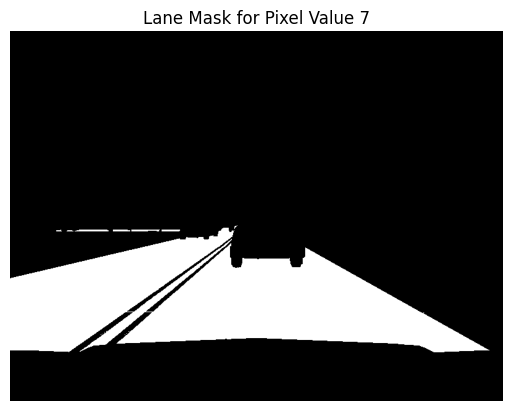

In [34]:
def extract_lane_mask(mask, lane_value):
    """Convert the mask to binary, keeping only the lane class."""
    binary_mask = (mask == lane_value).astype(np.uint8)
    return binary_mask

# Load a random mask sample for debugging
random_index = random.randint(0, len(mask_paths) - 1)
mask_sample = np.array(Image.open(mask_paths[random_index]))  # Shape: (H, W, 3)

# Reduce to 2D (assuming class labels are in all channels or first channel)
mask_sample = mask_sample[:, :, 0]  # Shape: (H, W)
print("mask_sample shape:", mask_sample.shape)
print("mask_sample dtype:", mask_sample.dtype)
print("Unique values in mask_sample:", np.unique(mask_sample))

# Extract lane mask
lane_value = 7
lane_mask = extract_lane_mask(mask_sample, lane_value)
print("lane_mask shape:", lane_mask.shape)
print("Unique values in lane_mask:", np.unique(lane_mask))
print("Number of lane pixels:", lane_mask.sum())

# Visualize the lane mask
plt.imshow(lane_mask, cmap='gray', vmin=0, vmax=1)  # Explicit range for binary
plt.title(f"Lane Mask for Pixel Value {lane_value}")
plt.axis("off")
plt.show()

Making the Dataloader class

In [35]:


class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, lane_value=7):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.lane_value = lane_value

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Load mask
        mask = np.array(Image.open(mask_path))[:, :, 0]  # Assuming mask is RGB and class info is in the first channel

        # Extract lane mask
        lane_mask = (mask == self.lane_value).astype(np.uint8)

        # Define common transformations (flip and rotate)
        common_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
        ])

        # Apply common transformations to both image and mask
        augmented = common_transform(image=np.array(image), mask=lane_mask)
        image_augmented = augmented['image']
        mask_augmented = augmented['mask']

        # Define specific transformations for image (resize and color jitter)
        transform_image_specific = A.Compose([
            A.Resize(256, 256, interpolation=cv2.INTER_LINEAR),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
            A.ToTensorV2()
        ])

        # Define specific transformations for mask (resize with nearest neighbor)
        transform_mask_specific = A.Compose([
            A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
            A.ToTensorV2()
        ])

        # Apply specific transformations
        image_transformed = transform_image_specific(image=image_augmented)
        image = image_transformed['image']

        mask_transformed = transform_mask_specific(image=mask_augmented)
        lane_mask = mask_transformed['image']

        # Convert lane_mask to float tensor
        lane_mask = lane_mask.float()

        return image, lane_mask

Making the Dataloader

In [36]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Split Dataset
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, train_size=4000, random_state=42
)
val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(
    val_img_paths, val_mask_paths, test_size=200, random_state=42
)

# Create Datasets
train_dataset = SegmentationDataset(train_img_paths, train_mask_paths, transform=train_transforms)
val_dataset = SegmentationDataset(val_img_paths, val_mask_paths, transform=val_transforms)
test_dataset = SegmentationDataset(test_img_paths, test_mask_paths, transform=val_transforms)

Making Dataloader

In [37]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 4000, Val samples: 800, Test samples: 200


Train Dataset Samples


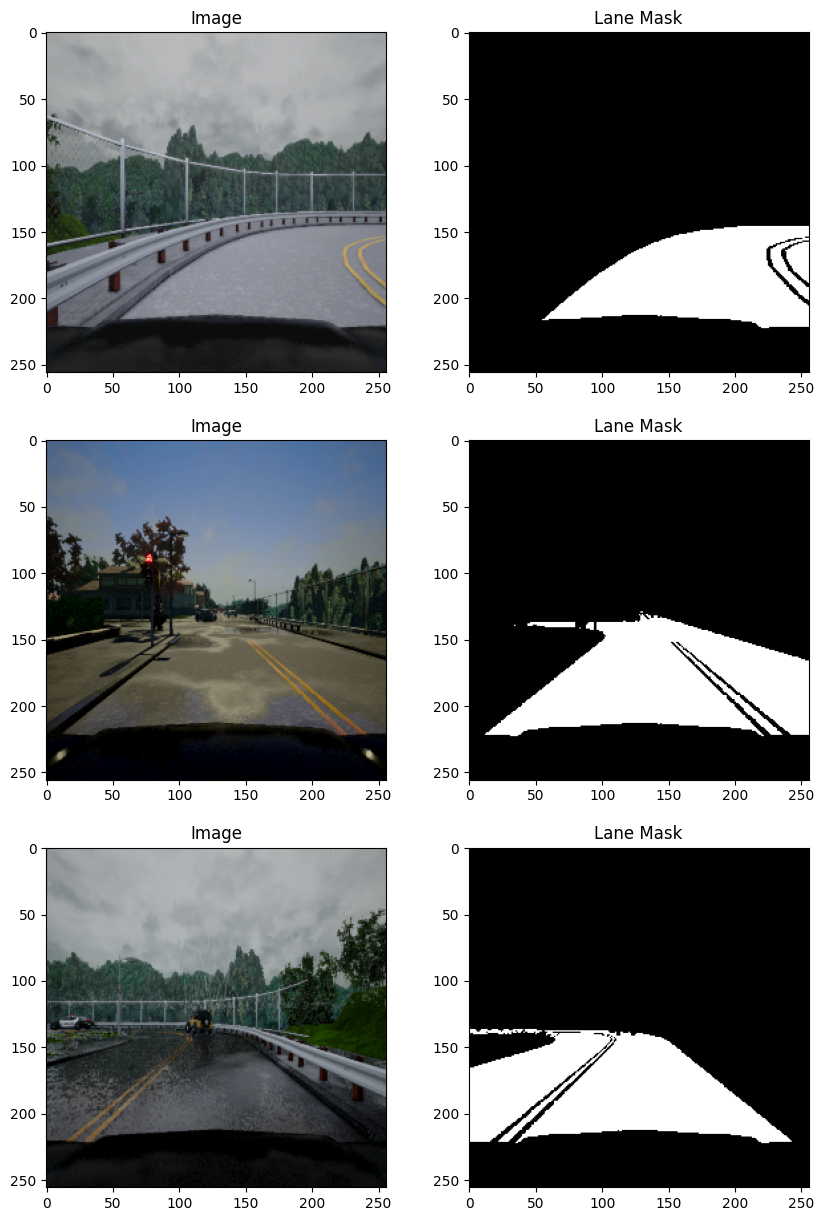

Validation Dataset Samples


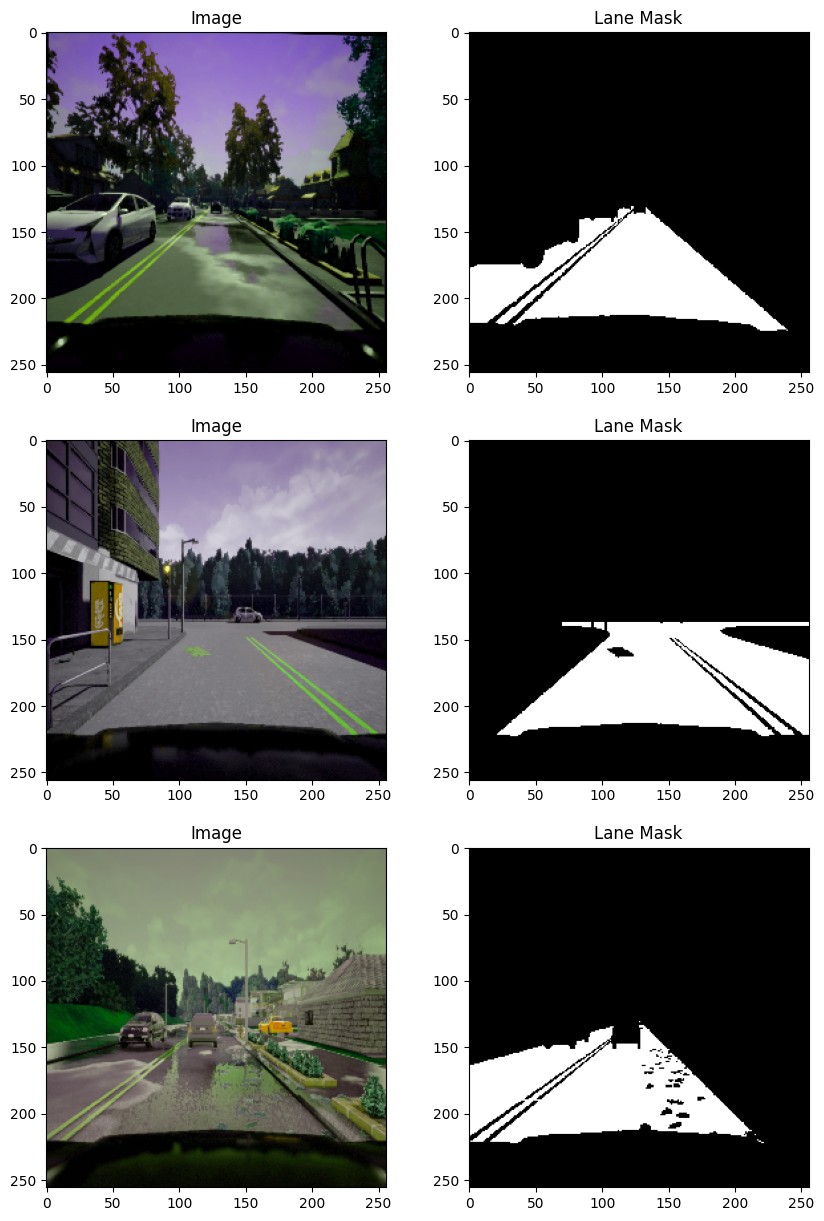

Test Dataset Samples


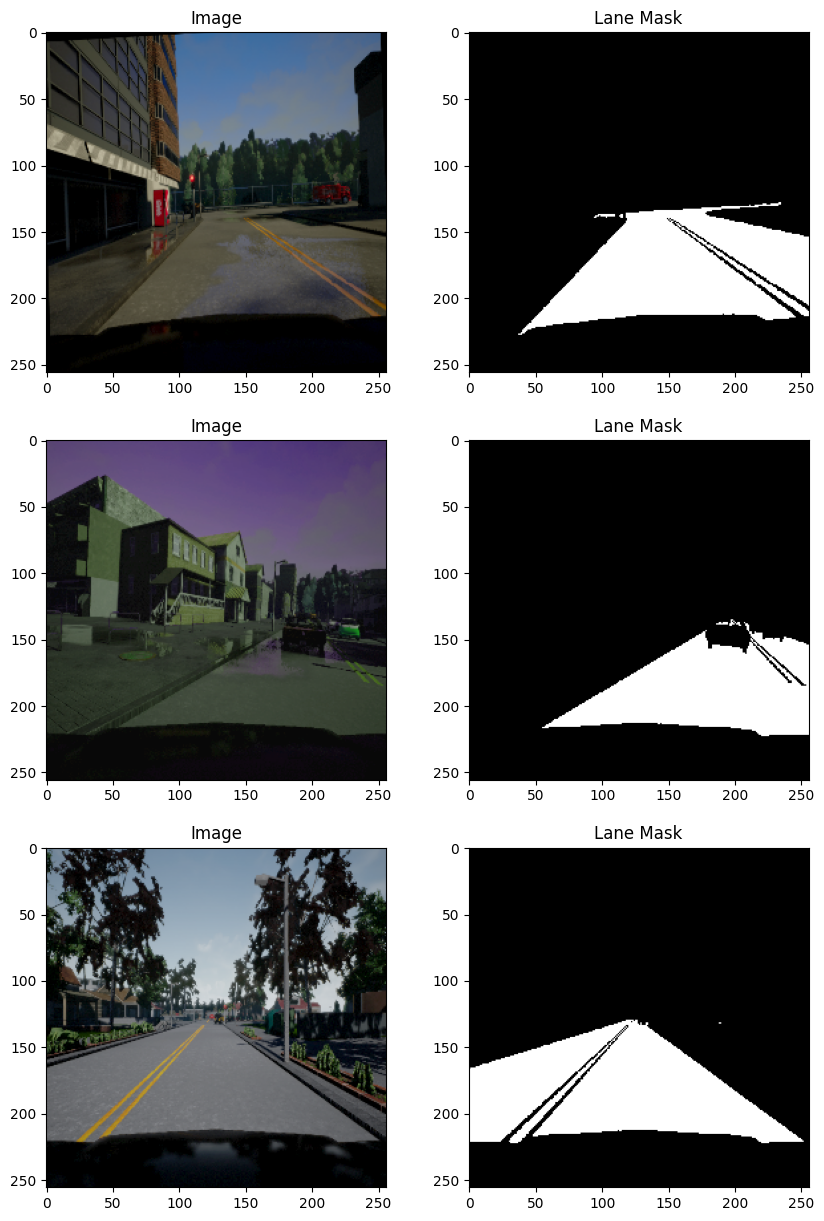

In [38]:
import cv2
def display_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        image, mask = dataset[idx]
        # Convert tensor to numpy array for display
        image_np = image.permute(1, 2, 0).numpy()
        mask_np = mask[0].numpy()  # Assuming mask is (1, H, W)
        axes[i][0].imshow(image_np)
        axes[i][0].set_title('Image')
        axes[i][1].imshow(mask_np, cmap='gray')
        axes[i][1].set_title('Lane Mask')
    plt.show()

# Display samples for each dataset
print("Train Dataset Samples")
display_samples(train_dataset)

print("Validation Dataset Samples")
display_samples(val_dataset)

print("Test Dataset Samples")
display_samples(test_dataset)

Checking wheather the pipeline is providing the binary segmented lane mask or not

Mask shape: (600, 800)
Mask dtype: uint8
Unique values in mask: [ 0  1  2  3  5  6  7  8  9 10 12]
Lane mask shape: (600, 800)
Unique values in lane mask: [0 1]
Lane mask sum: 97551


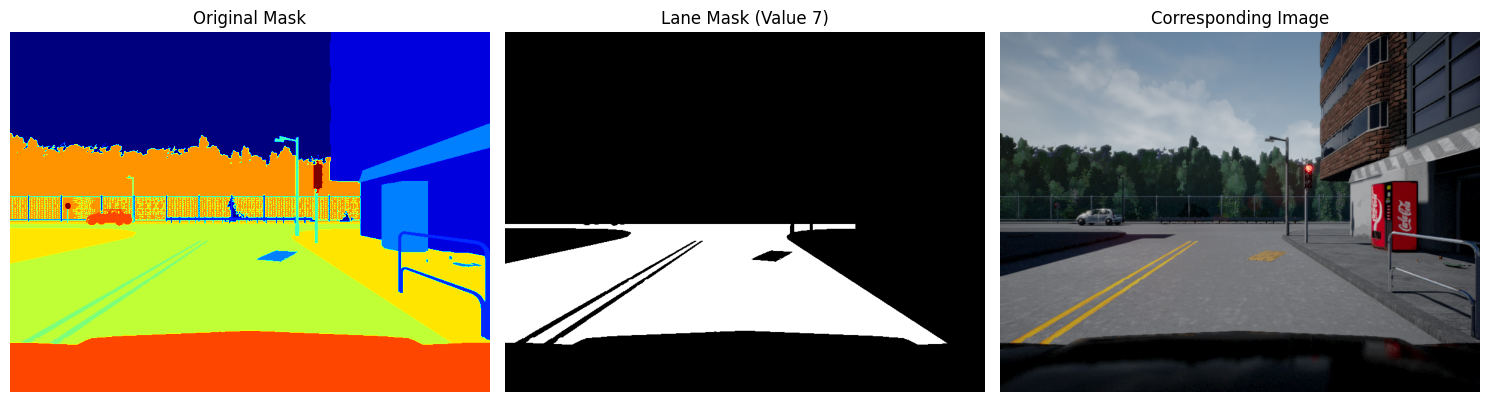

In [39]:
def check_lane_mask(image_paths, mask_paths, lane_value=7):
    # Randomly select an index
    random_index = np.random.randint(0, len(mask_paths))
    
    # Load mask as RGB and convert to single-channel (assuming class values are consistent across channels)
    mask_rgb = np.array(Image.open(mask_paths[random_index]))  # Shape: (600, 800, 3)
    mask = mask_rgb[:, :, 0]  # Take one channel (assuming class info is in all channels equally)
    
    # Print mask information
    print("Mask shape:", mask.shape)  # Should be (600, 800)
    print("Mask dtype:", mask.dtype)
    print("Unique values in mask:", np.unique(mask))
    
    # Extract lane mask (now 2D)
    lane_mask = (mask == lane_value).astype(np.uint8)  # Shape: (600, 800)
    
    # Print lane mask information
    print("Lane mask shape:", lane_mask.shape)
    print("Unique values in lane mask:", np.unique(lane_mask))
    print("Lane mask sum:", lane_mask.sum())
    
    # Visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original mask (single channel)
    axs[0].imshow(mask, cmap='jet')  # Use 'jet' colormap to distinguish classes
    axs[0].set_title("Original Mask")
    axs[0].axis('off')
    
    # Grayscale lane mask (binary)
    axs[1].imshow(lane_mask, cmap='gray')
    axs[1].set_title(f"Lane Mask (Value {lane_value})")
    axs[1].axis('off')
    
    # Load corresponding image
    image = np.array(Image.open(image_paths[random_index]))
    axs[2].imshow(image)
    axs[2].set_title("Corresponding Image")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test with your image and mask paths
check_lane_mask(image_paths, mask_paths)

**Making the U-Net Architecture**

Building the Encoder block

In [40]:
def conv_block(input_channels, num_filters):
    return nn.Sequential(
        nn.Conv2d(input_channels, num_filters, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True),
        nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True)
    )

def encoder_block(input_channels, num_filters):
    conv = conv_block(input_channels, num_filters)
    pool = nn.MaxPool2d(kernel_size=2, stride=2)
    return conv, pool

Building the Decoder Block

In [41]:
def decoder_block(input_channels, num_filters):
    up = nn.ConvTranspose2d(input_channels, num_filters, kernel_size=2, stride=2)
    conv = conv_block(num_filters * 2, num_filters)  # After concatenation, channels double
    return up, conv

**U-Net**

In [42]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.enc1, self.pool1 = encoder_block(in_channels, 64)
        self.enc2, self.pool2 = encoder_block(64, 128)
        self.enc3, self.pool3 = encoder_block(128, 256)
        self.enc4, self.pool4 = encoder_block(256, 512)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)
        
        # Decoder
        self.up1, self.conv1 = decoder_block(1024, 512)
        self.up2, self.conv2 = decoder_block(512, 256)
        self.up3, self.conv3 = decoder_block(256, 128)
        self.up4, self.conv4 = decoder_block(128, 64)
        
        # Final Layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Encoder
        s1 = self.enc1(x)    # [B, 64, 256, 256]
        p1 = self.pool1(s1)  # [B, 64, 128, 128]
        s2 = self.enc2(p1)   # [B, 128, 128, 128]
        p2 = self.pool2(s2)  # [B, 128, 64, 64]
        s3 = self.enc3(p2)   # [B, 256, 64, 64]
        p3 = self.pool3(s3)  # [B, 256, 32, 32]
        s4 = self.enc4(p3)   # [B, 512, 32, 32]
        p4 = self.pool4(s4)  # [B, 512, 16, 16]
        
        # Bottleneck
        b = self.bottleneck(p4)  # [B, 1024, 16, 16]
        
        # Decoder with skip connections
        d1 = self.up1(b)         # [B, 512, 32, 32]
        d1 = torch.cat([d1, s4], dim=1)  # [B, 1024, 32, 32]
        d1 = self.conv1(d1)      # [B, 512, 32, 32]
        
        d2 = self.up2(d1)        # [B, 256, 64, 64]
        d2 = torch.cat([d2, s3], dim=1)  # [B, 512, 64, 64]
        d2 = self.conv2(d2)      # [B, 256, 64, 64]
        
        d3 = self.up3(d2)        # [B, 128, 128, 128]
        d3 = torch.cat([d3, s2], dim=1)  # [B, 256, 128, 128]
        d3 = self.conv3(d3)      # [B, 128, 128, 128]
        
        d4 = self.up4(d3)        # [B, 64, 256, 256]
        d4 = torch.cat([d4, s1], dim=1)  # [B, 128, 256, 256]
        d4 = self.conv4(d4)      # [B, 64, 256, 256]
        
        # Output
        return torch.sigmoid(self.final(d4))  # [B, 1, 256, 256]

Switching to gpu

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Loss Function

In [44]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return bce_loss + dice_loss

MIoU and Dice Coefficient metrics

In [45]:
def calculate_metrics(preds, targets, threshold=0.5, smooth=1e-5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=[2, 3])
    union = preds.sum(dim=[2, 3]) + targets.sum(dim=[2, 3]) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    miou = iou.mean()
    
    dice = (2. * intersection + smooth) / (preds.sum(dim=[2, 3]) + targets.sum(dim=[2, 3]) + smooth)
    dice = dice.mean()
    
    return miou.item(), dice.item()

**Training and Validation Loop**

In [46]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_miou = 0
    train_losses, val_losses, train_mious, val_mious, train_dices, val_dices = [], [], [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_miou, train_dice = 0, 0, 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Convert images to float32 and normalize (assuming images are in 0-255 range)
            images = images.to(device, dtype=torch.float32) / 255.0  # Convert to float and normalize to [0, 1]
            masks = masks.to(device, dtype=torch.float32)  # Ensure masks are also float
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            miou, dice = calculate_metrics(outputs, masks)  # Assuming this function is defined
            train_loss += loss.item() * images.size(0)
            train_miou += miou * images.size(0)
            train_dice += dice * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_miou /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)
        
        model.eval()
        val_loss, val_miou, val_dice = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                # Convert images to float32 and normalize
                images = images.to(device, dtype=torch.float32) / 255.0
                masks = masks.to(device, dtype=torch.float32)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                miou, dice = calculate_metrics(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_miou += miou * images.size(0)
                val_dice += dice * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_miou /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mious.append(train_miou)
        val_mious.append(val_miou)
        train_dices.append(train_dice)
        val_dices.append(val_dice)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, MIoU: {train_miou:.4f}, Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f}, MIoU: {val_miou:.4f}, Dice: {val_dice:.4f}")
        
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            torch.save(model.state_dict(), 'best_unet_model.pth')
    
    return train_losses, val_losses, train_mious, val_mious, train_dices, val_dices

**Executing the Training**

In [47]:
model = UNet(in_channels=3, out_channels=1).to(device)
criterion = DiceBCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)  # Removed verbose=True
num_epochs = 50

In [48]:
train_losses, val_losses, train_mious, val_mious, train_dices, val_dices = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

Epoch 1/50: 100%|██████████| 250/250 [03:17<00:00,  1.26it/s]


Epoch 1/50
Train Loss: 0.2757, MIoU: 0.8363, Dice: 0.8972
Val Loss: 0.1759, MIoU: 0.8768, Dice: 0.9276


Epoch 2/50: 100%|██████████| 250/250 [03:16<00:00,  1.27it/s]


Epoch 2/50
Train Loss: 0.0691, MIoU: 0.9465, Dice: 0.9720
Val Loss: 0.0604, MIoU: 0.9533, Dice: 0.9756


Epoch 3/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 3/50
Train Loss: 0.0512, MIoU: 0.9598, Dice: 0.9792
Val Loss: 0.0530, MIoU: 0.9589, Dice: 0.9787


Epoch 4/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 4/50
Train Loss: 0.0438, MIoU: 0.9648, Dice: 0.9819
Val Loss: 0.0378, MIoU: 0.9695, Dice: 0.9843


Epoch 5/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 5/50
Train Loss: 0.0348, MIoU: 0.9716, Dice: 0.9855
Val Loss: 0.0317, MIoU: 0.9740, Dice: 0.9867


Epoch 6/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 6/50
Train Loss: 0.0467, MIoU: 0.9629, Dice: 0.9807
Val Loss: 0.0437, MIoU: 0.9658, Dice: 0.9822


Epoch 7/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 7/50
Train Loss: 0.0324, MIoU: 0.9733, Dice: 0.9864
Val Loss: 0.0308, MIoU: 0.9747, Dice: 0.9871


Epoch 8/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 8/50
Train Loss: 0.0325, MIoU: 0.9733, Dice: 0.9863
Val Loss: 0.0269, MIoU: 0.9776, Dice: 0.9886


Epoch 9/50: 100%|██████████| 250/250 [03:17<00:00,  1.26it/s]


Epoch 9/50
Train Loss: 0.0274, MIoU: 0.9772, Dice: 0.9884
Val Loss: 0.0287, MIoU: 0.9762, Dice: 0.9878


Epoch 10/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 10/50
Train Loss: 0.0258, MIoU: 0.9782, Dice: 0.9889
Val Loss: 0.1140, MIoU: 0.9447, Dice: 0.9711


Epoch 11/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 11/50
Train Loss: 0.0351, MIoU: 0.9716, Dice: 0.9854
Val Loss: 0.0311, MIoU: 0.9752, Dice: 0.9874


Epoch 12/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 12/50
Train Loss: 0.0249, MIoU: 0.9790, Dice: 0.9893
Val Loss: 0.0259, MIoU: 0.9782, Dice: 0.9889


Epoch 13/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 13/50
Train Loss: 0.0275, MIoU: 0.9771, Dice: 0.9883
Val Loss: 0.0244, MIoU: 0.9794, Dice: 0.9895


Epoch 14/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 14/50
Train Loss: 0.0234, MIoU: 0.9800, Dice: 0.9899
Val Loss: 0.0314, MIoU: 0.9750, Dice: 0.9872


Epoch 15/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 15/50
Train Loss: 0.0243, MIoU: 0.9795, Dice: 0.9896
Val Loss: 0.0236, MIoU: 0.9801, Dice: 0.9898


Epoch 16/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 16/50
Train Loss: 0.0249, MIoU: 0.9792, Dice: 0.9894
Val Loss: 0.0265, MIoU: 0.9783, Dice: 0.9889


Epoch 17/50: 100%|██████████| 250/250 [03:17<00:00,  1.26it/s]


Epoch 17/50
Train Loss: 0.0219, MIoU: 0.9814, Dice: 0.9906
Val Loss: 0.0370, MIoU: 0.9714, Dice: 0.9851


Epoch 18/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 18/50
Train Loss: 0.0210, MIoU: 0.9821, Dice: 0.9909
Val Loss: 0.6938, MIoU: 0.8027, Dice: 0.8879


Epoch 19/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 19/50
Train Loss: 0.0297, MIoU: 0.9759, Dice: 0.9876
Val Loss: 0.0194, MIoU: 0.9835, Dice: 0.9916


Epoch 20/50: 100%|██████████| 250/250 [03:17<00:00,  1.26it/s]


Epoch 20/50
Train Loss: 0.0179, MIoU: 0.9846, Dice: 0.9922
Val Loss: 0.0173, MIoU: 0.9852, Dice: 0.9925


Epoch 21/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 21/50
Train Loss: 0.0173, MIoU: 0.9850, Dice: 0.9924
Val Loss: 0.0173, MIoU: 0.9851, Dice: 0.9924


Epoch 22/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 22/50
Train Loss: 0.0195, MIoU: 0.9834, Dice: 0.9916
Val Loss: 0.0188, MIoU: 0.9841, Dice: 0.9919


Epoch 23/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 23/50
Train Loss: 0.0166, MIoU: 0.9856, Dice: 0.9927
Val Loss: 0.0170, MIoU: 0.9853, Dice: 0.9926


Epoch 24/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 24/50
Train Loss: 0.0164, MIoU: 0.9858, Dice: 0.9928
Val Loss: 0.0315, MIoU: 0.9747, Dice: 0.9869


Epoch 25/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 25/50
Train Loss: 0.0248, MIoU: 0.9796, Dice: 0.9896
Val Loss: 0.0883, MIoU: 0.9406, Dice: 0.9673


Epoch 26/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 26/50
Train Loss: 0.0238, MIoU: 0.9803, Dice: 0.9900
Val Loss: 0.0206, MIoU: 0.9827, Dice: 0.9912


Epoch 27/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 27/50
Train Loss: 0.0176, MIoU: 0.9849, Dice: 0.9924
Val Loss: 0.0160, MIoU: 0.9862, Dice: 0.9930


Epoch 28/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 28/50
Train Loss: 0.0152, MIoU: 0.9867, Dice: 0.9933
Val Loss: 0.0148, MIoU: 0.9870, Dice: 0.9935


Epoch 29/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 29/50
Train Loss: 0.0173, MIoU: 0.9853, Dice: 0.9926
Val Loss: 0.0220, MIoU: 0.9818, Dice: 0.9907


Epoch 30/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 30/50
Train Loss: 0.0158, MIoU: 0.9863, Dice: 0.9931
Val Loss: 0.0147, MIoU: 0.9871, Dice: 0.9935


Epoch 31/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 31/50
Train Loss: 0.0145, MIoU: 0.9873, Dice: 0.9936
Val Loss: 0.0146, MIoU: 0.9873, Dice: 0.9936


Epoch 32/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 32/50
Train Loss: 0.0153, MIoU: 0.9868, Dice: 0.9933
Val Loss: 0.0146, MIoU: 0.9874, Dice: 0.9936


Epoch 33/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 33/50
Train Loss: 0.0138, MIoU: 0.9878, Dice: 0.9939
Val Loss: 0.0135, MIoU: 0.9882, Dice: 0.9940


Epoch 34/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 34/50
Train Loss: 0.0128, MIoU: 0.9887, Dice: 0.9943
Val Loss: 0.0129, MIoU: 0.9887, Dice: 0.9943


Epoch 35/50: 100%|██████████| 250/250 [03:17<00:00,  1.26it/s]


Epoch 35/50
Train Loss: 0.0134, MIoU: 0.9883, Dice: 0.9941
Val Loss: 0.0186, MIoU: 0.9850, Dice: 0.9924


Epoch 36/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 36/50
Train Loss: 0.0245, MIoU: 0.9802, Dice: 0.9898
Val Loss: 0.1551, MIoU: 0.9039, Dice: 0.9420


Epoch 37/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 37/50
Train Loss: 0.0198, MIoU: 0.9833, Dice: 0.9915
Val Loss: 0.0191, MIoU: 0.9837, Dice: 0.9917


Epoch 38/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 38/50
Train Loss: 0.0165, MIoU: 0.9858, Dice: 0.9928
Val Loss: 0.0148, MIoU: 0.9872, Dice: 0.9936


Epoch 39/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 39/50
Train Loss: 0.0135, MIoU: 0.9882, Dice: 0.9940
Val Loss: 0.0135, MIoU: 0.9882, Dice: 0.9941


Epoch 40/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 40/50
Train Loss: 0.0130, MIoU: 0.9885, Dice: 0.9942
Val Loss: 0.0130, MIoU: 0.9887, Dice: 0.9943


Epoch 41/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 41/50
Train Loss: 0.0128, MIoU: 0.9887, Dice: 0.9943
Val Loss: 0.0131, MIoU: 0.9886, Dice: 0.9942


Epoch 42/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 42/50
Train Loss: 0.0126, MIoU: 0.9889, Dice: 0.9944
Val Loss: 0.0129, MIoU: 0.9886, Dice: 0.9943


Epoch 43/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 43/50
Train Loss: 0.0125, MIoU: 0.9890, Dice: 0.9944
Val Loss: 0.0129, MIoU: 0.9887, Dice: 0.9943


Epoch 44/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 44/50
Train Loss: 0.0124, MIoU: 0.9891, Dice: 0.9945
Val Loss: 0.0128, MIoU: 0.9887, Dice: 0.9943


Epoch 45/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 45/50
Train Loss: 0.0123, MIoU: 0.9891, Dice: 0.9945
Val Loss: 0.0127, MIoU: 0.9889, Dice: 0.9944


Epoch 46/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 46/50
Train Loss: 0.0121, MIoU: 0.9893, Dice: 0.9946
Val Loss: 0.0123, MIoU: 0.9891, Dice: 0.9945


Epoch 47/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 47/50
Train Loss: 0.0119, MIoU: 0.9894, Dice: 0.9947
Val Loss: 0.0126, MIoU: 0.9889, Dice: 0.9944


Epoch 48/50: 100%|██████████| 250/250 [03:17<00:00,  1.26it/s]


Epoch 48/50
Train Loss: 0.0119, MIoU: 0.9895, Dice: 0.9947
Val Loss: 0.0126, MIoU: 0.9890, Dice: 0.9944


Epoch 49/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 49/50
Train Loss: 0.0119, MIoU: 0.9895, Dice: 0.9947
Val Loss: 0.0123, MIoU: 0.9893, Dice: 0.9946


Epoch 50/50: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]


Epoch 50/50
Train Loss: 0.0117, MIoU: 0.9897, Dice: 0.9948
Val Loss: 0.0121, MIoU: 0.9893, Dice: 0.9946


**Plotting the Results**

In [52]:
# Assuming calculate_metrics is defined elsewhere in your code

def plot_metrics(train_losses, val_losses, train_mious, val_mious, train_dices, val_dices):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_mious, label='Train MIoU')
    plt.plot(epochs_range, val_mious, label='Val MIoU')
    plt.title('MIoU')
    plt.xlabel('Epoch')
    plt.ylabel('MIoU')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, train_dices, label='Train Dice')
    plt.plot(epochs_range, val_dices, label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_and_visualize(model, test_loader, criterion, device, num_samples=3):
    model.eval()
    test_loss, test_miou, test_dice = 0, 0, 0
    images_list, masks_list, preds_list = [], [], []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            # Convert images to float32 and normalize (matching training preprocessing)
            images = images.to(device, dtype=torch.float32) / 255.0  # Assuming uint8 input range 0-255
            masks = masks.to(device, dtype=torch.float32)  # Ensure masks are float

            outputs = model(images)
            loss = criterion(outputs, masks)
            miou, dice = calculate_metrics(outputs, masks)
            
            test_loss += loss.item() * images.size(0)
            test_miou += miou * images.size(0)
            test_dice += dice * images.size(0)
            
            if i == 0:  # Take from first batch
                images_list.extend(images[:num_samples].cpu())
                masks_list.extend(masks[:num_samples].cpu())
                preds_list.extend((outputs[:num_samples] > 0.5).float().cpu())
            if len(images_list) >= num_samples:
                break
    
    test_loss /= len(test_loader.dataset)
    test_miou /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, MIoU: {test_miou:.4f}, Dice: {test_dice:.4f}")

    # Visualization
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        img = images_list[i].permute(1, 2, 0).numpy()
        # If you normalized by /255 during training, no need to denormalize with ImageNet stats
        # Just clip to [0, 1] since training input was in [0, 1]
        img = np.clip(img, 0, 1)

        mask = masks_list[i].squeeze().numpy()
        pred = preds_list[i].squeeze().numpy()

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Original Mask")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Plotting Results

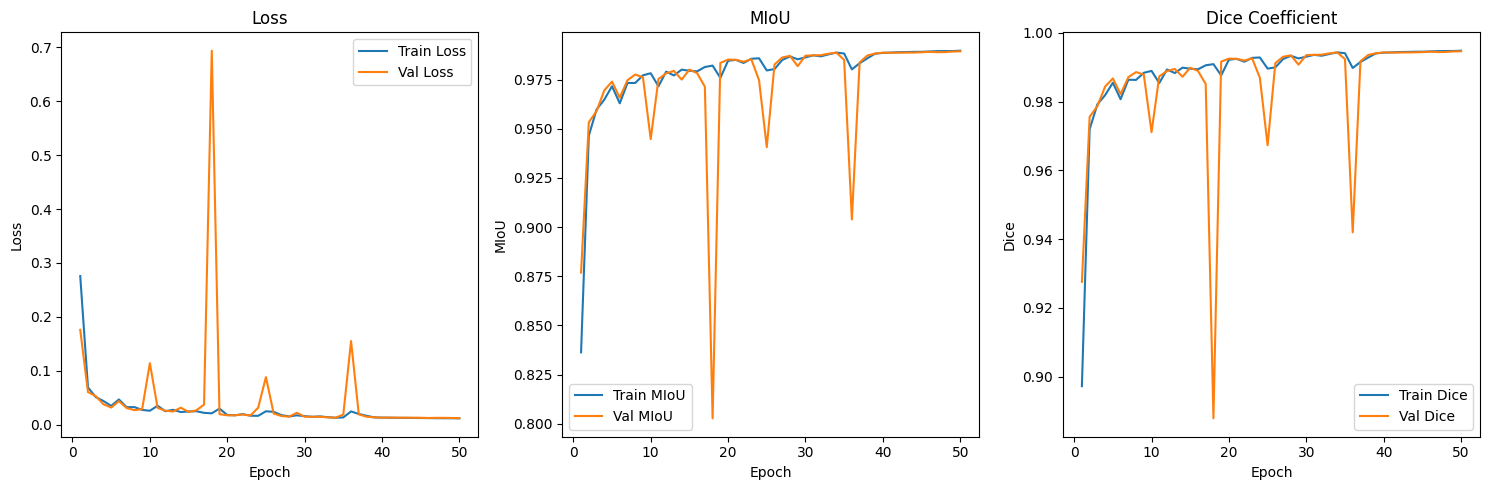

In [54]:
plot_metrics(train_losses, val_losses, train_mious, val_mious, train_dices, val_dices)

Test Loss: 0.0011, MIoU: 0.0790, Dice: 0.0795


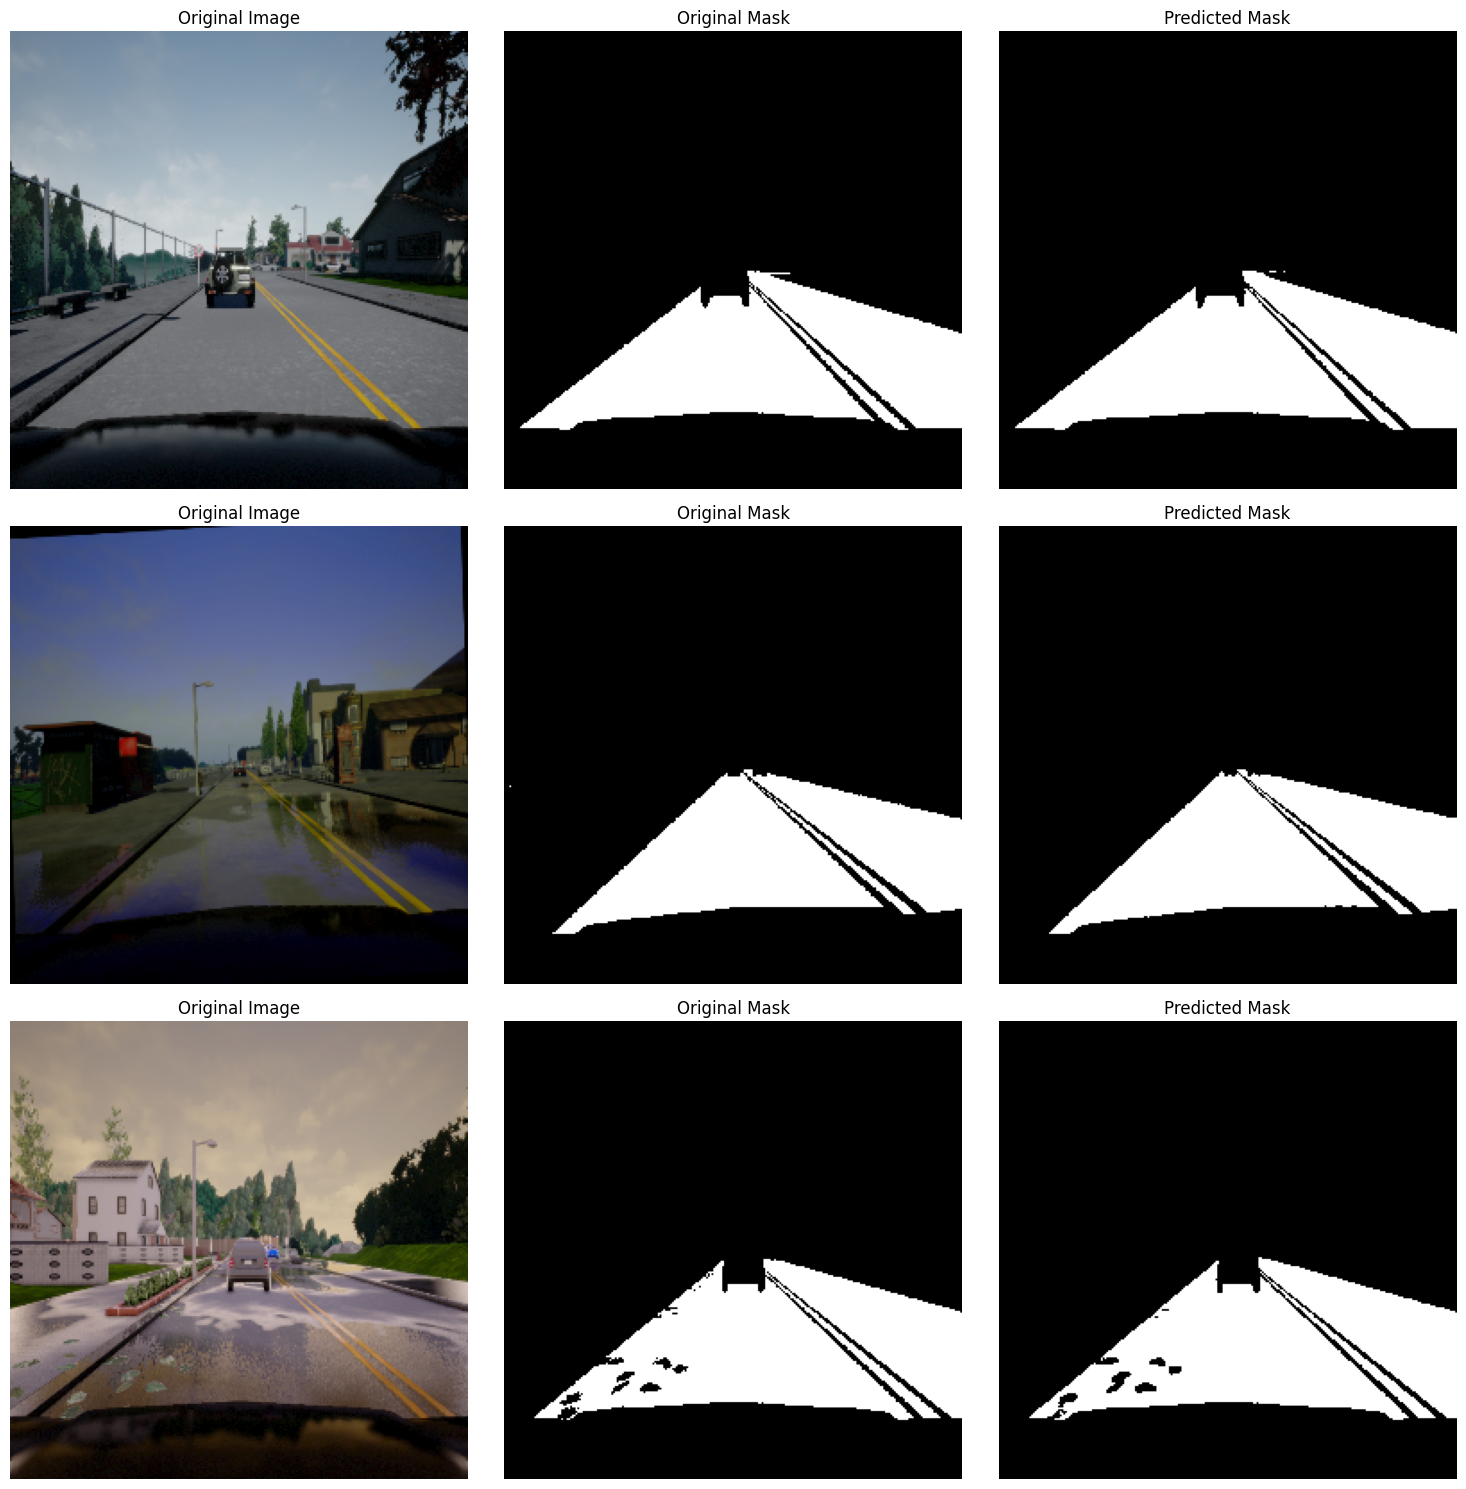

In [53]:
evaluate_and_visualize(model, test_loader, criterion, device, num_samples=3)

**Saving the Model**

In [56]:
model.load_state_dict(torch.load('best_unet_model.pth'))

<ipython-input-56-34032cecd07e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unet_model.pth'))


<All keys matched successfully>